In [207]:
import akshare as ak
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Invest according to MA

In [236]:
# df = pd.read_csv('sp500.csv')
# https://fred.stlouisfed.org/series/SP500
df = pd.read_csv('sp500_19_20.csv', ); 
df.columns = ['Date', 'Close']; df = df[df.Close != '.']; df['Close'] = df['Close'].astype(float)

In [263]:
def get_invest(data, is_verbal=False):
    n_stock = 0.0
    Money = 100.0
    sign = 0
    for i in data.iterrows():
        sign = i[1]['sign_change']
        if i[0] == 0 or (sign == 1 and Money > 0):
            n_stock = Money / i[1]['Close']
            if is_verbal:
                print(f'''On {i[1]['Date']}, open price is {i[1]['Close']}, spend {Money:.1f} money to get {n_stock:.4f} stocks''')
            Money = 0.0
        if sign == -1 and n_stock > 0:
            Money = n_stock * i[1]['Close']
            n_stock = 0.0
            if is_verbal:
                print(f'''On {i[1]['Date']}, open price is {i[1]['Close']}, sell all stocks to get {Money:.1f} cash''')
    if is_verbal:
        print(f'''On {i[1]['Date']}, have {Money:.1f}, and {i[1]['Close'] * n_stock:.1f} worth of stock''')
    return Money + i[1]['Close'] * n_stock

In [238]:
# t1 = 10; t2 = 20

results_train = []
for t1 in range(5, 50, 5):
    for t2 in range(10, 100, 10):
        if t2 <= t1:
            continue
        # df['ma_t1'] = df.Close.rolling(t1).mean()
        # df['ma_t2'] = df.Close.rolling(t2).mean()
        df['ma_t1'] = df.Close.ewm(span=t1).mean()
        df['ma_t2'] = df.Close.ewm(span=t2).mean()

        df['d_t1_t2'] = df['ma_t1'] - df['ma_t2']
        df['d_t1_t2_sign'] = df['d_t1_t2'] > 0
        df['sign_change'] = (df['d_t1_t2_sign'] - df['d_t1_t2_sign'].shift())

        dfp = df[(df.Date > '2018-12-31') & (df.Date <= '2019-12-31')].copy().reset_index(drop=True)

        results_train.append((get_invest(dfp), t1, t2))

In [239]:
results_test = []
for money_train, t1, t2 in sorted(results_train, reverse=True)[:20]:
    if t2 <= t1:
        continue
    # df['ma_t1'] = df.Close.rolling(t1).mean()
    # df['ma_t2'] = df.Close.rolling(t2).mean()
    df['ma_t1'] = df.Close.ewm(span=t1).mean()
    df['ma_t2'] = df.Close.ewm(span=t2).mean()

    df['d_t1_t2'] = df['ma_t1'] - df['ma_t2']
    df['d_t1_t2_sign'] = df['d_t1_t2'] > 0
    df['sign_change'] = (df['d_t1_t2_sign'] - df['d_t1_t2_sign'].shift())

    dfp = df[df.Date > '2019-12-31'].copy().reset_index(drop=True)
    results_test.append((get_invest(dfp), t1, t2))

In [264]:
# sorted(results_test, reverse=True)[:20]

# sorted(results_train, reverse=True)[:20]

5 20
On 2019-01-02, close price is 2510.03, spend 100.0 money to get 0.0398 stocks
On 2019-05-08, close price is 2879.42, sell all stocks to get 114.7 cash
On 2019-06-07, close price is 2873.34, spend 114.7 money to get 0.0399 stocks
On 2019-08-01, close price is 2953.56, sell all stocks to get 117.9 cash
On 2019-09-04, close price is 2937.78, spend 117.9 money to get 0.0401 stocks
On 2019-10-01, close price is 2940.25, sell all stocks to get 118.0 cash
On 2019-10-15, close price is 2995.68, spend 118.0 money to get 0.0394 stocks
On 2020-01-31, close price is 3225.52, sell all stocks to get 127.1 cash
On 2020-02-04, close price is 3297.59, spend 127.1 money to get 0.0385 stocks
On 2020-02-24, close price is 3225.89, sell all stocks to get 124.3 cash
On 2020-04-08, close price is 2749.98, spend 124.3 money to get 0.0452 stocks
On 2020-06-26, close price is 3009.05, sell all stocks to get 136.0 cash
On 2020-07-01, close price is 3115.86, spend 136.0 money to get 0.0437 stocks
On 2020-09-

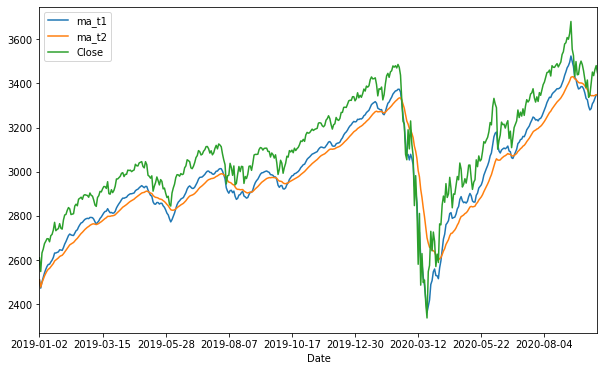

In [266]:
for money_train, t1, t2 in sorted(results_test, reverse=True)[:1]:
    if t2 <= t1:
        continue
    print(t1, t2)
    # df['ma_t1'] = df.Close.rolling(t1).mean()
    # df['ma_t2'] = df.Close.rolling(t2).mean()
    df['ma_t1'] = df.Close.ewm(span=t1).mean()
    df['ma_t2'] = df.Close.ewm(span=t2).mean()

    df['d_t1_t2'] = df['ma_t1'] - df['ma_t2']
    df['d_t1_t2_sign'] = df['d_t1_t2'] > 0
    df['sign_change'] = (df['d_t1_t2_sign'] - df['d_t1_t2_sign'].shift())

    dfp = df.copy().reset_index(drop=True)
    print((get_invest(dfp, is_verbal=True), t1, t2))
        
f, a = plt.subplots(figsize=(10, 6))
dfp.Close = dfp.Close + 100
dfp = dfp.set_index('Date')
dfp[['ma_t1', 'ma_t2', 'Close']].plot(ax=a                        )

In [267]:
(dfp.Close.tail(1).values / dfp.Close.head(1).values * 100)[0]

132.12261928023815

# Auto-correlation of SP500

In [2]:
stock_us_daily_df = ak.stock_us_daily(symbol="SPY", adjust="")
print(stock_us_daily_df)

              open    high       low   close      volume        amount
date                                                                  
1993-01-29   43.97   43.97   43.7500   43.94   1003200.0  0.000000e+00
1993-02-01   43.97   44.25   43.9700   44.25    480500.0  0.000000e+00
1993-02-02   44.22   44.38   44.1300   44.34    201300.0  0.000000e+00
1993-02-03   44.41   44.84   44.3800   44.81    529400.0  0.000000e+00
1993-02-04   44.97   45.09   44.8800   45.00    531500.0  0.000000e+00
...            ...     ...       ...     ...         ...           ...
2021-01-11  377.85  380.58  377.7189  378.69  44609389.0  6.975780e+10
2021-01-12  378.89  379.86  376.3600  378.77  45355896.0  6.975780e+10
2021-01-13  378.69  380.86  377.8500  379.79  38086512.0  6.975780e+10
2021-01-14  380.59  381.13  378.1000  378.46  40885938.0  6.975780e+10
2021-01-15  376.72  377.58  373.7000  375.70  77873321.0  6.975780e+10

[7037 rows x 6 columns]


In [3]:
df = stock_us_daily_df

price_type = 'close'
price_2020 = df.loc[(stock_us_daily_df.index.year == 2020) & (stock_us_daily_df.index.dayofyear <= 182), price_type]

In [143]:
w_len = len(price_2020)
corr = []
ds = []
ind = []
for i in range(0, len(df), 5):
    if i + w_len - 1 > len(df):
        break
    open_window = df.iloc[i:i+w_len, :][price_type]
    corr_v = np.corrcoef(price_2020, open_window)[0, 1]
    if corr_v > 0.7:
        ind.append(i)
        corr.append(corr_v)
        ds.append(open_window.index.values[0])

In [144]:
df_corr = pd.DataFrame([ind, ds, corr], index=['ind', 'date', 'corr']).T
n_days = 410

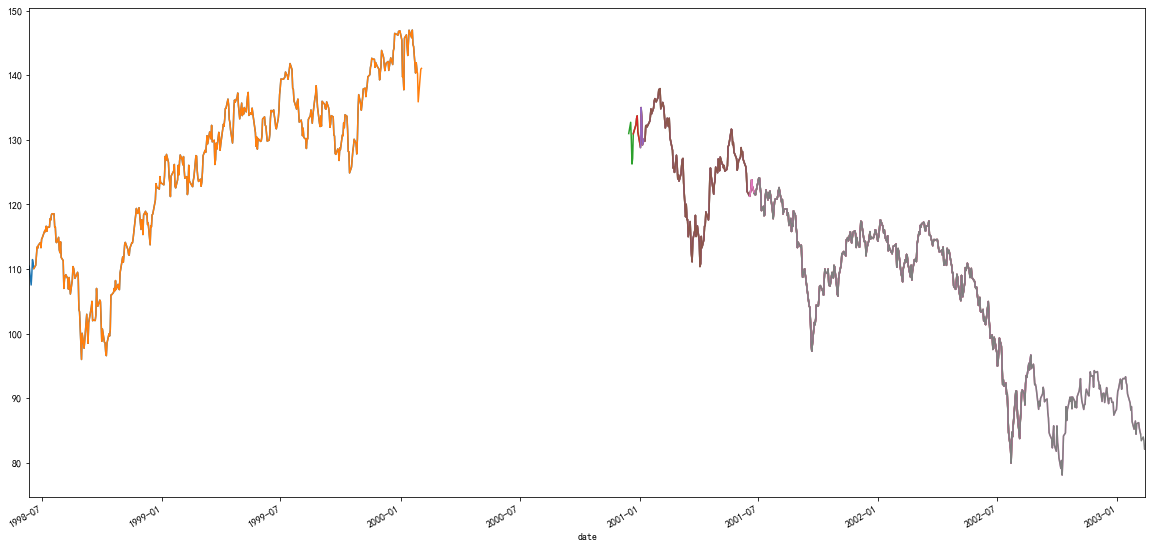

In [76]:
f, a = plt.subplots(figsize=(20, 10))
len_c = len(df_corr)
for i in df_corr.ind.values[:len_c // 4]:
    df.iloc[i:i+n_days, :][price_type].plot(ax=a)

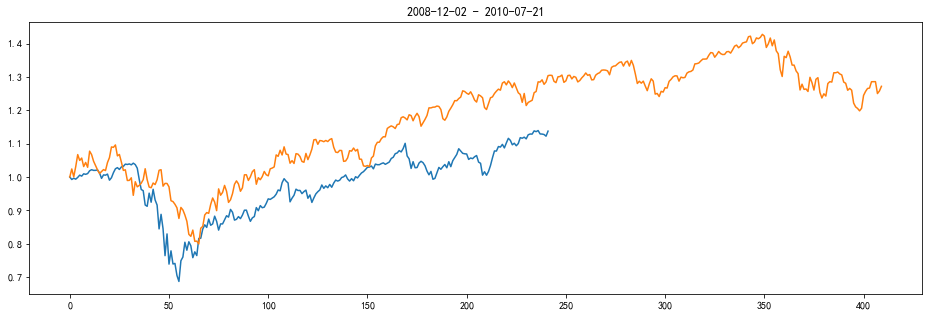

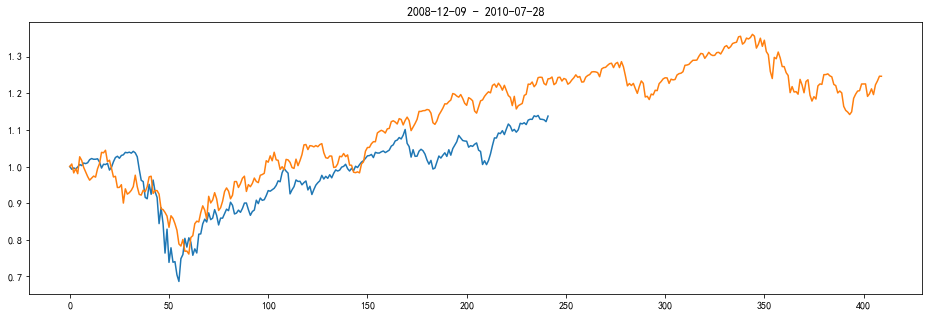

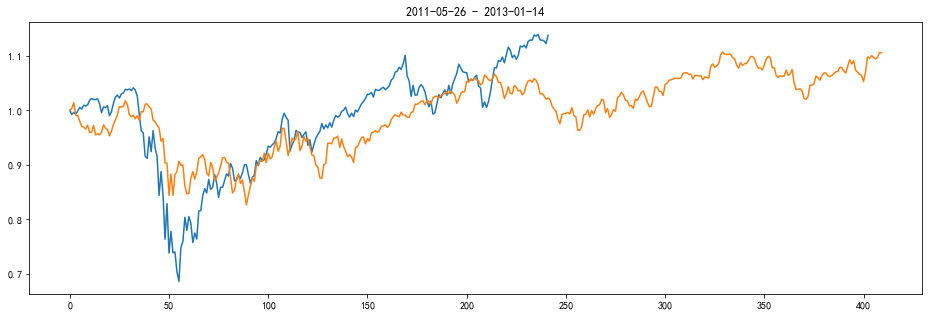

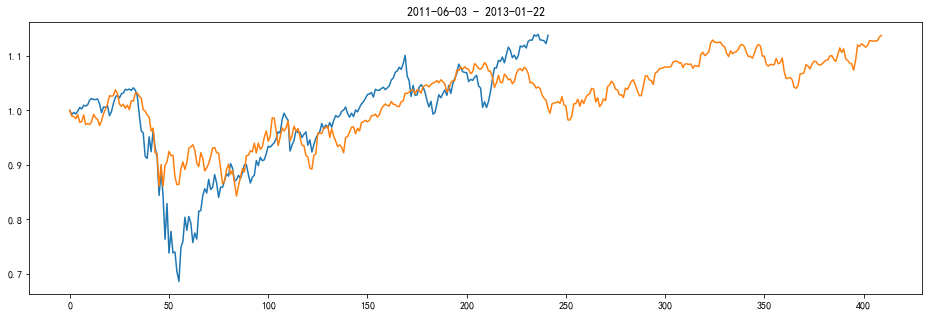

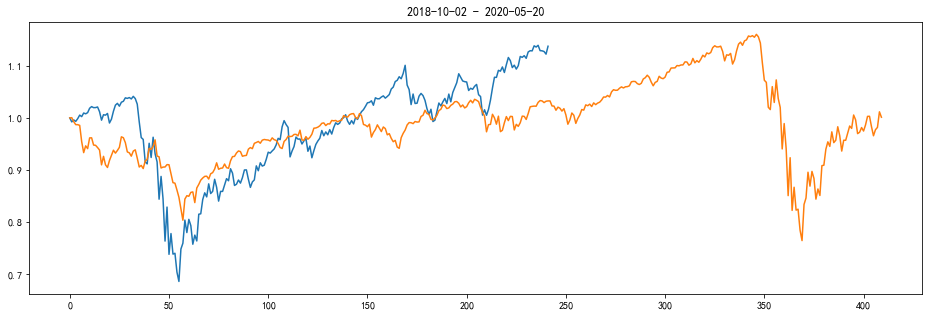

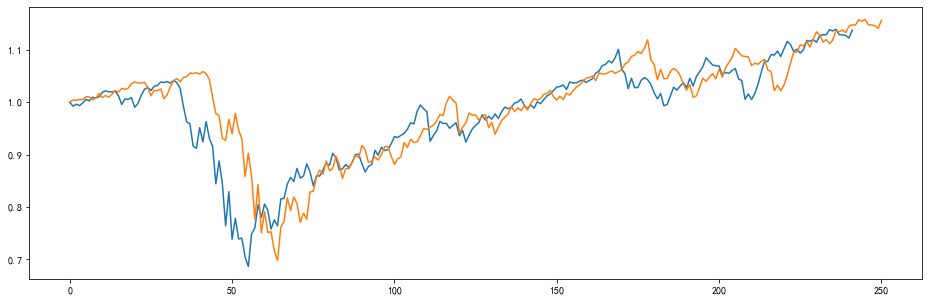

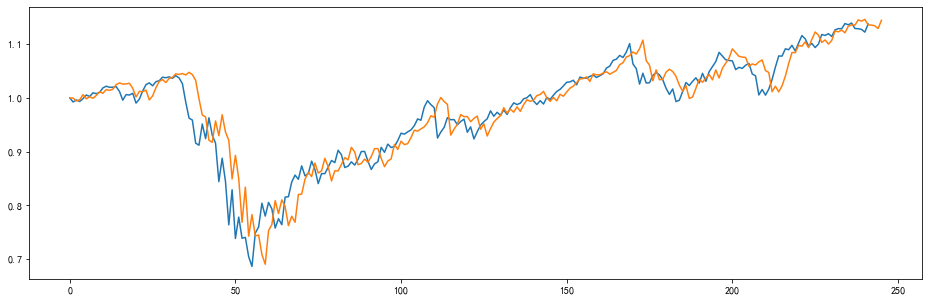

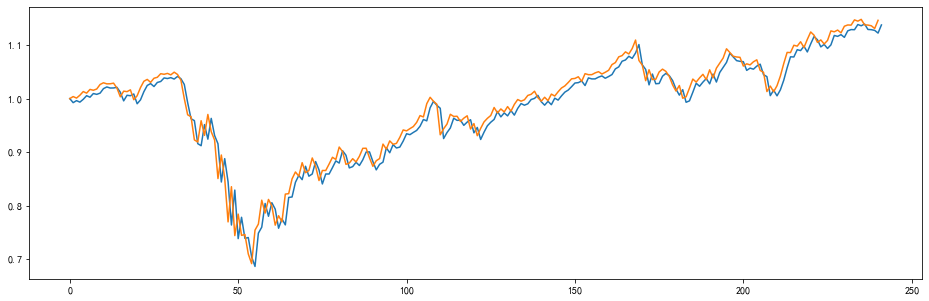

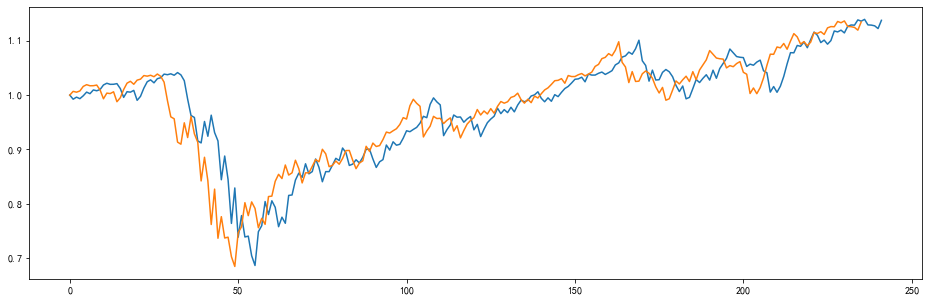

In [153]:
len_c = len(df_corr)
v0 = df.loc[(stock_us_daily_df.index.year == 2020), price_type].values.copy()
v0 = v0 / v0[0]
def plot_series(s, e):
    for i in df_corr.ind.values[s:e] :
        v1 = df.iloc[i:i+n_days, :][price_type].values.copy()
        v1 = v1 / v1[0]
        if v1[0] > v1[-1] or v1.min() > 0.85:
            continue
        f, a = plt.subplots(figsize=(16, 5))
        a.plot(v0)
        a.plot(v1)
        if i+n_days < len(df):
            a.set_title(f'{str(df.index[i].date())} - {str(df.index[i+n_days].date())}')
    
plot_series(s=0, e=len_c)

In [13]:
v0 = df.loc[df.index > pd.Timestamp('2020-01-01 00:00:00'), price_type]
v0 = v0 / v0.iloc[0]

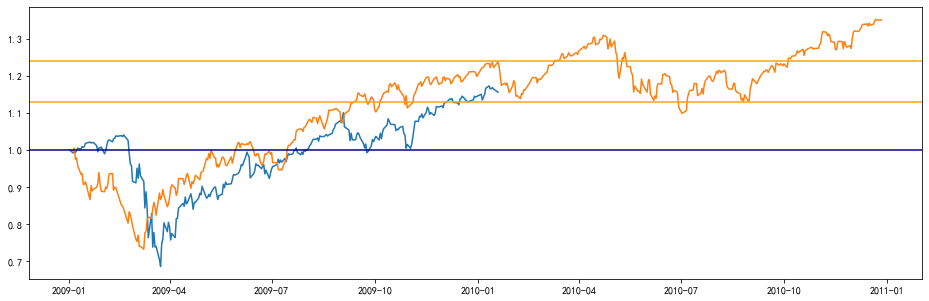

In [21]:
df_v1 = df.loc[(stock_us_daily_df.index.year.isin([2009, 2010])), price_type].iloc[:500].copy()
v1 = df_v1.values
v1 = v1 / v1[0]
f, a = plt.subplots(figsize=(16, 5))
a.plot(df_v1.index[:len(v0)], v0)
a.plot(df_v1.index, v1)
a.axhline(1.13, c='orange')
a.axhline(1.24, c='orange')
a.axhline(1.0, c='darkblue')


# Regression to check if the price is too far away from M2 and Earning

Ideas from https://seekingalpha.com/article/4396638-visa-fair-price-and-upside-potential

In [250]:
# From fred.stlouisfed.org
m2_weekly = pd.read_csv('M2.csv')
m2_weekly['DATE'] = pd.to_datetime(m2_weekly['DATE'])
m2_weekly['dayofyear'] = m2_weekly['DATE'].dt.dayofyear
m2_weekly['year'] = m2_weekly['DATE'].dt.year

def flat_doy(x):
    if x <= 90:
        x = 90
    elif x <= 181:
        x = 181
    elif x <= 273:
        x = 273
    else:
        x = 365
    return x
m2_weekly['flat_doy'] = m2_weekly['dayofyear'].apply(flat_doy)

m2_quarterly = m2_weekly.groupby(['year', 'flat_doy'], as_index=False)['M2'].mean()
m2_quarterly = m2_quarterly[m2_quarterly.year.between(1981, 2020)]

In [363]:
def get_stock_price(stock_symbol):
    stock_us_fundamental_df = ak.stock_us_fundamental(stock=stock_symbol, symbol="PE")
    stock_us_fundamental_df = stock_us_fundamental_df.sort_values('date').reset_index(drop=True)
    stock_us_fundamental_df = stock_us_fundamental_df.set_index('date')

    stock_us_fundamental_df['ttm_net_eps'] = stock_us_fundamental_df['ttm_net_eps'].str[1:]
    stock_us_fundamental_df['ttm_net_eps'] = stock_us_fundamental_df['ttm_net_eps'].astype(float)
    stock_us_fundamental_df['ttm_net_eps_prev_q'] = stock_us_fundamental_df['ttm_net_eps'].shift(1)
    stock_us_fundamental_df['ttm_net_eps_delta'] = \
        stock_us_fundamental_df['ttm_net_eps'] - stock_us_fundamental_df['ttm_net_eps_prev_q']
    stock_us_fundamental_df['ttm_net_eps_delta_frac'] = \
        stock_us_fundamental_df['ttm_net_eps_delta'] / stock_us_fundamental_df['ttm_net_eps_prev_q']
    stock_us_fundamental_df['price_next_q'] = stock_us_fundamental_df['stock_price'].shift(-1)
    stock_us_fundamental_df['m2'] = m2_quarterly.iloc[-len(stock_us_fundamental_df):, -1].values
    stock_us_fundamental_df['ttm_net_eps_norm'] = \
        stock_us_fundamental_df['ttm_net_eps'] / stock_us_fundamental_df['m2']
    stock_us_fundamental_df = stock_us_fundamental_df.iloc[1:-1, :]
    
    return stock_us_fundamental_df

def plot_predictions(stock_us_fundamental_df, y_name):
    stock_us_fundamental_df['m2_normalized'] = stock_us_fundamental_df['m2'] /\
        stock_us_fundamental_df['m2'].mean() * stock_us_fundamental_df[y_name].mean()
    stock_us_fundamental_df['ttm_net_eps_normalized'] = stock_us_fundamental_df['ttm_net_eps'] /\
        stock_us_fundamental_df['ttm_net_eps'].mean() * stock_us_fundamental_df[y_name].mean()
    stock_us_fundamental_df[[y_name, 'predictions', 
    #                          'm2_normalized', 'ttm_net_eps_normalized'
                            ]].iloc[-160:, :].plot()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     208.9
Date:                Wed, 20 Jan 2021   Prob (F-statistic):           5.58e-11
Time:                        08:13:39   Log-Likelihood:                -104.87
No. Observations:                  19   AIC:                             213.7
Df Residuals:                      17   BIC:                             215.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2111.2148    211.425     -9.986      0.0

c:\users\yuwei\tools\env\penv\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


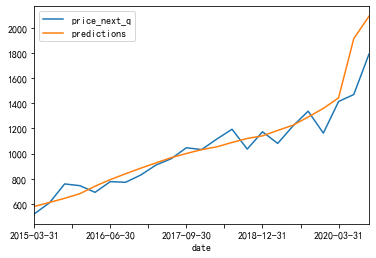

In [368]:
stock_symbol = 'GOOG'
df = get_stock_price(stock_symbol)
# print(df.tail())

import statsmodels.api as sm
feature_name = [
#     'ttm_net_eps', 
    'm2',
#     'ttm_net_eps_norm'
#     'ttm_net_eps_delta',
#     'ttm_net_eps_delta_frac'
#     'pe_ratio',
]
y_name = 'price_next_q' # 'stock_price'

# Remove 2020 when training models
df_train = df.iloc[:-4, :]
X = sm.add_constant(df_train[feature_name].values)
y = df_train[y_name].values
model = sm.OLS(y, X).fit()

X_pred = sm.add_constant(df[feature_name].values)
df['predictions'] = model.predict(X_pred)
print(model.summary())

plot_predictions(df, y_name)

# Earning
* For AAPL, if the the day before earning closed low, but on that day before close and hold for 16 days
* For WMT, similar, but don't buy if low in more than 1 day before

## Check how days before earning can predict price after

In [138]:
from datetime import datetime
from datetime import timedelta
from yahoo_earnings_calendar import YahooEarningsCalendar
import dateutil.parser

def get_earning(ticker, DAYS_AHEAD=-1900):
    # setting the dates
    start_date = (datetime.now().date() + timedelta(days=DAYS_AHEAD))
    end_date = datetime.now().date()

    # downloading the earnings calendar
    yec = YahooEarningsCalendar()
    earnings_list = yec.get_earnings_of(ticker)
    earnings_df = pd.DataFrame(earnings_list)

    # extracting the date from the string and filtering for the period of interest
    earnings_df['report_date'] = earnings_df['startdatetime'].apply(lambda x: dateutil.parser.isoparse(x).date())
    earnings_df = earnings_df.loc[earnings_df['report_date'].between(start_date, end_date)] \
                             .sort_values('report_date')

    return earnings_df

In [229]:
symbol = 'MCD'
er_ds_df = get_earning(symbol)
# er_ds_dict = {symbol: [pd.Timestamp(i) for i in er_ds_df.report_date.values]}
er_ds = [pd.Timestamp(i) for i in er_ds_df.report_date.values]
df_stock_price_for_er = ak.stock_us_daily(symbol=symbol, adjust="")

In [230]:
day_hold_range = [16] # range(7, 25)
for day_hold in day_hold_range:
    profit_sum = []
    for day_er in er_ds:
        er_ind = np.where(df_stock_price_for_er.index == day_er)[0][0]
        df_er = df_stock_price_for_er.iloc[er_ind - 2:er_ind + 40, :]
        df_er['close_prev_day'] = df_er['close'].shift(1)
        df_er['dip'] = (df_er['close'] - df_er['close_prev_day']) < 0
        df_er = df_er.iloc[1:day_hold, :]
        if df_er['dip'].values[0]:
            buy_price = df_er['close'].values[0]
            sell_price = df_er['close'].values[-1]
            gain = (sell_price - buy_price) / buy_price
            if len(day_hold_range) == 1:
                print(f'Date: {df_er.index.values[0]}. Profit: {gain * 100:.3}%')
            profit_sum.append(gain)
    print(f'Sell on the {day_hold - 2}th trading day; Avg profit: {np.mean(profit_sum) * 100:.3}%')

Date: 2016-04-21T00:00:00.000000000. Profit: 2.66%
Date: 2016-07-25T00:00:00.000000000. Profit: -6.19%
Date: 2016-10-20T00:00:00.000000000. Profit: 3.99%
Date: 2017-07-24T00:00:00.000000000. Profit: 3.59%
Date: 2017-10-23T00:00:00.000000000. Profit: 1.38%
Date: 2018-01-29T00:00:00.000000000. Profit: -11.2%
Date: 2018-04-27T00:00:00.000000000. Profit: 1.9%
Date: 2018-10-22T00:00:00.000000000. Profit: 11.6%
Date: 2019-01-29T00:00:00.000000000. Profit: -1.6%
Date: 2019-04-29T00:00:00.000000000. Profit: 1.07%
Sell on the 14th trading day; Avg profit: 0.715%


## Get future earning date for some stocks

In [231]:
def get_earning(ticker, DAYS_AHEAD=30):
    # setting the dates
    start_date = datetime.now().date()
    end_date = datetime.now().date() + timedelta(days=DAYS_AHEAD)

    # downloading the earnings calendar
    yec = YahooEarningsCalendar()
    earnings_list = yec.get_earnings_of(ticker)
    earnings_df = pd.DataFrame(earnings_list)

    # extracting the date from the string and filtering for the period of interest
    earnings_df['report_date'] = earnings_df['startdatetime'].apply(lambda x: dateutil.parser.isoparse(x).date())
    earnings_df = earnings_df.loc[earnings_df['report_date'].between(start_date, end_date)] \
                             .sort_values('report_date')

    return earnings_df

In [235]:
df_er_select = pd.DataFrame()
for symbol in ['AAPL', 'DIS', 'GOOG', 'KO', 'MSFT', 'WMT',]:
    df_er_select = df_er_select.append(get_earning(symbol))
df_er_select = df_er_select.sort_values('report_date')

In [ ]:
df_er_select.append(get_earning(symbol))

In [242]:
df_er_select[['ticker', 'report_date']]

,ticker,report_date
3,MSFT,2021-01-26
3,AAPL,2021-01-27
3,KO,2021-02-10
3,DIS,2021-02-11
4,WMT,2021-02-18


# test

# bakcup 

In [109]:
er_ds_dict = {'AAPL': [pd.Timestamp('2018-02-01'),
         pd.Timestamp('2018-05-01'),
         pd.Timestamp('2018-07-31'),
         pd.Timestamp('2018-11-01'),
         pd.Timestamp('2019-01-29'),
         pd.Timestamp('2019-04-30'),
         pd.Timestamp('2019-07-30'),
         pd.Timestamp('2019-10-30'),
         pd.Timestamp('2020-01-29'),
         pd.Timestamp('2020-04-30'),
         pd.Timestamp('2020-07-30'),
         pd.Timestamp('2020-10-29'),
        ],
  }

# df_stock_price_for_er = ak.stock_us_daily(symbol=symbol, adjust="")
